In [43]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('training.csv')

In [44]:
df.drop(columns=['segment_id'], inplace=True)
df.head()

,wellbore_chev_no_id,area_id,formation_id,bit_model_id,drillbit_size,min_depth,max_depth,rate_of_penetration,surface_weight_on_bit,surface_rpm
0,wellbore_chev_no_0,area_0,formation_62,bit_model_1,12.25,21834.5,21839.5,99.614650,43.533280,150.369091
1,wellbore_chev_no_0,area_0,formation_61,bit_model_1,12.25,21840.0,21869.5,99.354021,42.382033,150.369001
2,wellbore_chev_no_0,area_0,formation_59,bit_model_1,12.25,21870.0,21899.5,83.622907,48.675129,150.429335
3,wellbore_chev_no_0,area_0,formation_65,bit_model_1,12.25,21900.0,21929.5,85.427731,30.041290,150.080000
4,wellbore_chev_no_0,area_0,formation_65,bit_model_1,12.25,21930.0,21959.5,100.639811,31.406319,150.032167


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6838 entries, 0 to 6837
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   wellbore_chev_no_id    6838 non-null   object 
 1   area_id                6838 non-null   object 
 2   formation_id           6838 non-null   object 
 3   bit_model_id           6838 non-null   object 
 4   drillbit_size          6838 non-null   float64
 5   min_depth              6838 non-null   float64
 6   max_depth              6838 non-null   float64
 7   rate_of_penetration    6838 non-null   float64
 8   surface_weight_on_bit  6838 non-null   float64
 9   surface_rpm            6838 non-null   float64
dtypes: float64(6), object(4)
memory usage: 534.3+ KB


In [46]:
from numpy import percentile
def remove_outliers(column, df):
    q25, q75 = percentile(df[column], 25), percentile(df[column], 75)
    cut_off = 1.5 * (q75 - q25)
    lower, upper = q25 - cut_off, q75 + cut_off
    new_df = df[(df[column] < upper) & (df[column] > lower)]
    return new_df

print(f"Dataset size before removing outliers: {df.shape[0]}")
df = remove_outliers('rate_of_penetration', df)
print(f"Dataset size after removing outliers: {df.shape[0]}")
df.reset_index(drop=True, inplace=True)

Dataset size before removing outliers: 6838
Dataset size after removing outliers: 6735


In [47]:
enc = OneHotEncoder(handle_unknown='error', sparse=False)
nominal = ['wellbore_chev_no_id', 'area_id', 'formation_id', 'bit_model_id']
numerical = ['drillbit_size', 'min_depth', 'max_depth', 'surface_weight_on_bit', 'surface_rpm']

X_nominal = enc.fit_transform(df[nominal])
nominal_cols = enc.get_feature_names_out(nominal)

scaler = StandardScaler()
X_num = df[numerical].copy()

for i in numerical:
    X_num[i] = scaler.fit_transform(df[[i]])

X = np.concatenate((X_nominal, X_num), axis=1)
print(X.shape)
y = df['rate_of_penetration'].values

(6735, 305)


In [48]:
enc_cols = np.concatenate((nominal_cols, numerical))
enc_cols.shape

(305,)

In [49]:
cv_outer = KFold(n_splits=10, shuffle=True)

cross_test_scores = list()
BestK = []
for train_ix, test_ix in cv_outer.split(X):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    K = [1, 3, 5, 7, 9, 11, 15, 21, 31, 41, 51, 61, 71, 81, 91, 101]
    test_scores = []
    for k in K:
        knn = KNeighborsRegressor(k)
        knn.fit(X_train,y_train)
        test_scores.append(knn.score(X_test,y_test))
    knn = KNeighborsRegressor(K[test_scores.index(max(test_scores))])
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    # store the result
    BestK.append(K[test_scores.index(max(test_scores))])
    cross_test_scores.append(rmse)
    print(f'Best K: {K[test_scores.index(max(test_scores))]}, RMSE: {rmse}')
print(f'Overall RMSE: {round(np.mean(cross_test_scores), 3)} (sd: {round(np.std(cross_test_scores), 3)})')

Best K: 3, RMSE: 15.81487321320227
Best K: 9, RMSE: 14.820053803870415
Best K: 5, RMSE: 13.02965574895035
Best K: 5, RMSE: 14.323453528403553
Best K: 3, RMSE: 13.926186498303531
Best K: 7, RMSE: 14.422690025440037
Best K: 5, RMSE: 14.712396448391189
Best K: 5, RMSE: 15.497950725113684
Best K: 3, RMSE: 14.643728512415878
Best K: 3, RMSE: 12.599144971732677
Overall RMSE: 14.379 (sd: 0.943)


In [50]:
cv = KFold(n_splits=10, shuffle=True)
RFC = RandomForestRegressor(n_estimators=100, oob_score=True)
cv_scores = cross_val_score(RFC, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
RFC_rmse = np.sqrt(-cv_scores)
print(f'CV RMSE: {round(np.mean(RFC_rmse), 3)} (sd: {round(np.std(RFC_rmse), 3)})')

CV RMSE: 13.346 (sd: 0.77)


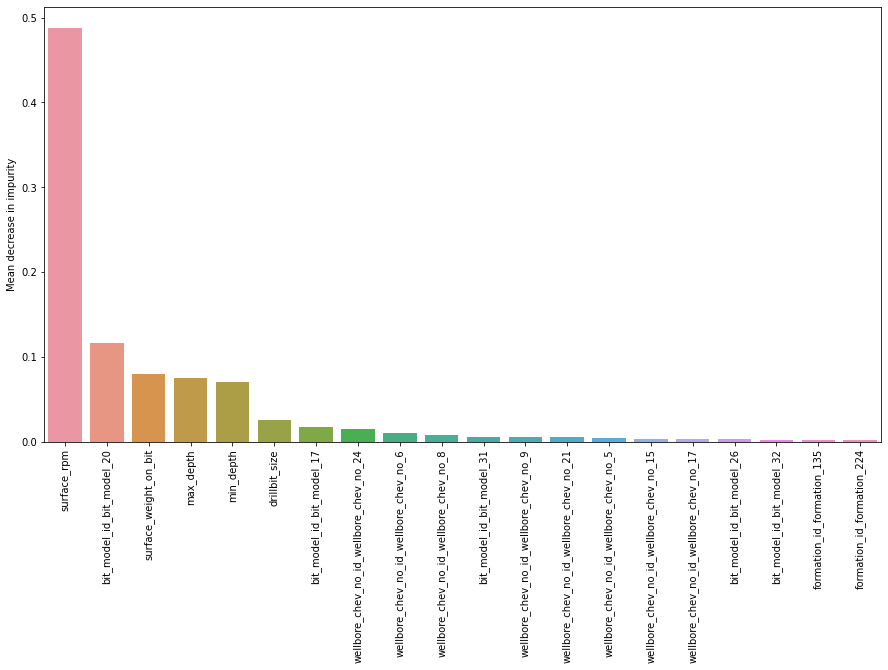

In [51]:
# Gini importances graph
RFC.fit(X, y)
importances = RFC.feature_importances_
importances = pd.DataFrame(importances, index=enc_cols, columns=['Values'])
importances = importances.sort_values(by='Values', ascending=False).head(20)
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(y=importances['Values'], x=importances.index, order=importances.sort_values(by='Values', ascending=False).index, ax=ax)
ax.set_ylabel('Mean decrease in impurity')
plt.xticks(rotation=90)
plt.show()

In [42]:
params = {
    'max_depth': [3, 5, 6, 8, 9, 10, 11, 12, 14, 16],
    'min_child_weight': np.arange(0.0001, 0.5, 0.001),
    'gamma': np.arange(0, 30, 0.005),
    'learning_rate': np.arange(0.0005, 0.3, 0.0005),
    'subsample': np.arange(0.01, 1, 0.01),
    'colsample_bylevel': np.round(np.arange(0.1, 1, 0.01)),
    'colsample_bytree': np.arange(0.1, 1, 0.01)
    }
kfold = KFold(n_splits=5, shuffle=True, random_state=10)
XGB = XGBRegressor(objective ='reg:squarederror', tree_method='gpu_hist')    
grid_search = RandomizedSearchCV(XGB, params, scoring="neg_mean_squared_error", n_iter = 500, cv=kfold, n_jobs=-1, verbose=10)
grid_result = grid_search.fit(X, y)

print('Best parameters:', grid_result.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters: {'subsample': 0.9500000000000001, 'min_child_weight': 0.1121, 'max_depth': 12, 'learning_rate': 0.14, 'gamma': 2.715, 'colsample_bytree': 0.7599999999999997, 'colsample_bylevel': 1.0}


In [52]:
cv = KFold(n_splits=10, shuffle=True)
XGB = XGBRegressor()    
XGB = XGBRegressor(subsample= 0.95, min_child_weight= 0.1121, max_depth= 12, learning_rate= 0.14, gamma= 2.715, colsample_bytree= 0.756, colsample_bylevel= 1.0, objective ='reg:squarederror', tree_method='gpu_hist')
cv_scores = cross_val_score(XGB, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
XGB_rmse = np.sqrt(-cv_scores)
print(f'CV RMSE: {round(np.mean(XGB_rmse), 3)} (sd: {round(np.std(XGB_rmse), 3)})')

CV RMSE: 13.254 (sd: 0.593)
